# **TinyML on Arduino**

In [ ]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.0.0-rc1

Mount Google Drive for Data Loading

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Load data, then parse and prepare the data

In [ ]:
import os
import sys

drive_dir = os.path.join('/content/drive/My Drive/')
data_dir = os.path.join(drive_dir, 'IoT_Data_Science', 'mini_project')

import numpy as np
import struct
import cv2

import matplotlib.pyplot as plt

# The list of subjects captured in front of the door (asusmption)
SUBJECTS = [
    's01', 's02', 's03', 's04'
]

# Create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_SUBJECTS = np.eye(len(SUBJECTS))

inputs = []
outputs = []

subjects = os.listdir(data_dir) # s01: namjo, s02: hyeonho, s03: haksun, s04: geonha
for s in subjects:
  sub_data_dir = os.path.join(data_dir, s)
  for i in range(10):
    # raw_img_f = open(os.path.join(sub_data_dir, s+'_'+str(i+1).zfill(3)+'.txt'), 'r')
    raw_bytes = np.load(os.path.join(sub_data_dir, s+'_'+str(i+1).zfill(3)+'.npy'))
    
    img = np.zeros((len(raw_bytes)*2, 1), dtype=int)
    for ii in range(len(raw_bytes)):
      # Read 16-bit grayscale pixels
      pixel = struct.unpack('>h', raw_bytes[ii])[0]
      img[2*ii] = (pixel & 0xFF00) >> 8
      img[2*ii +1] = (pixel & 0x00FF)

    img = np.reshape(img, (240, 320, 1)) # QVGA resolution
    img = img[60:120, 80:240, :] # Assumption
    # plt.imshow(img, cmap='gray')
    # plt.show()
    img = cv2.resize(img.astype('float32'), dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    img = np.expand_dims(img, axis=-1)
    # img = img.astype('uint8')

    inputs.append(img)
    outputs.append(ONE_HOT_ENCODED_SUBJECTS[SUBJECTS.index(s)])
    # print (ONE_HOT_ENCODED_SUBJECTS[SUBJECTS.index(s)])

# Convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print ("Data preparation DONE ...")

Data preparation DONE ...


## Randomize and split the input and output pairs for training
Per-class items should be split equally. 

In [ ]:
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings 
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.4 * num_inputs + TRAIN_SPLIT)

x_train, x_test = np.split(inputs, [TRAIN_SPLIT])
y_train, y_test = np.split(outputs, [TRAIN_SPLIT])

# # assert (x_train.size + x_test.size) == num_inputs
# print (inputs.shape)
# print (x_train.shape)
# print (x_test.shape)

# print (y_test)

print ('Dataset randomization and splitting DONE ...')

Dataset randomization and splitting DONE ...


In [ ]:
print (x_train.shape)
print (y_train.shape)

(24, 112, 112, 1)
(24, 4)


## Build and Train the TinyML Model


In [ ]:
from tensorflow.python.ops.init_ops_v2 import GlorotUniform
# Build the Conv2D model for extracting features from image
# import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
    # Conv2d layers
    keras.layers.BatchNormalization(input_shape=(240, 320, 1)), 
    keras.layers.Conv2D(
        filters=16, kernel_size=(3, 3), padding='same', 
        activation=keras.activations.relu, 
        kernel_initializer=keras.initializers.HeNormal(seed=1115),
    ), 
    keras.layers.Conv2D(
        filters=16, kernel_size=(3, 3), padding='same', 
        activation=keras.activations.relu, 
        kernel_initializer=keras.initializers.HeNormal(seed=1115), 
    ), 
    keras.layers.MaxPooling2D(pool_size=(2, 2)), 

    keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), padding='same', 
        activation=keras.activations.relu, 
        kernel_initializer=keras.initializers.HeNormal(seed=1115), 
    ), 
    keras.layers.MaxPooling2D(pool_size=(2, 2)), 

    keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), padding='same', 
        activation=keras.activations.relu, 
        kernel_initializer=keras.initializers.HeNormal(seed=1115), 
    ), 
    keras.layers.MaxPooling2D(pool_size=(3, 3)), 

    keras.layers.Dropout(
        rate=0.5
    ), 
    keras.layers.Flatten(), 
    keras.layers.Dense(
        units=64, 
        activation=keras.activations.relu, 
        kernel_initializer=keras.initializers.GlorotUniform(seed=1115),
    ),
    keras.layers.Dense(
        units=4, 
        activation=keras.activations.softmax, 
        kernel_initializer=keras.initializers.GlorotUniform(seed=1115),
    )
])

print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 240, 320, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 240, 320, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 320, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 160, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 160, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 80, 32)       0

In [ ]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(), 
    metrics=[
        keras.metrics.CategoricalAccuracy(),
    ]
)

In [ ]:
history = model.fit(
    x=x_train, 
    y=y_train,
    batch_size=1, 
    epochs=50, 
    validation_data=(x_test, y_test)
)

Epoch 1/50
24/24 [==============================] - 4s 22ms/step - loss: 2.2921 - categorical_accuracy: 0.3333 - val_loss: 3.2981 - val_categorical_accuracy: 0.3750
Epoch 2/50
24/24 [==============================] - 0s 10ms/step - loss: 1.8392 - categorical_accuracy: 0.3750 - val_loss: 2.8958 - val_categorical_accuracy: 0.2500
Epoch 3/50
24/24 [==============================] - 0s 10ms/step - loss: 1.4620 - categorical_accuracy: 0.2500 - val_loss: 1.6394 - val_categorical_accuracy: 0.1875
Epoch 4/50
24/24 [==============================] - 0s 9ms/step - loss: 1.1062 - categorical_accuracy: 0.5833 - val_loss: 1.3567 - val_categorical_accuracy: 0.3750
Epoch 5/50
24/24 [==============================] - 0s 9ms/step - loss: 0.8499 - categorical_accuracy: 0.6250 - val_loss: 1.0411 - val_categorical_accuracy: 0.5000
Epoch 6/50
24/24 [==============================] - 0s 10ms/step - loss: 0.8560 - categorical_accuracy: 0.7083 - val_loss: 1.1485 - val_categorical_accuracy: 0.6875
Epoch 7/50
2

## Graph the loss
Graph the loss to see when the model stops improving.

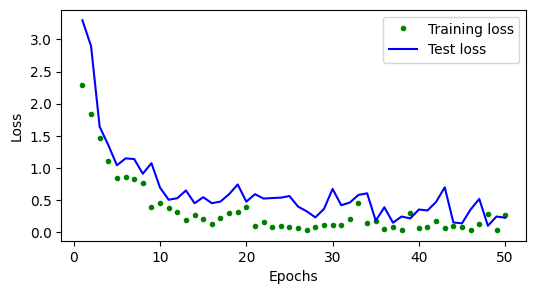

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 3)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Run with Test Data
Test data is same with validation data used in our model training, since we have limited number of data.

In [ ]:
# predictions = model.predict(x_test)

# print ('predictions =\n', np.round(predictions, decimals=3))
# print ('actual =\n', y_test)

from sklearn.metrics import accuracy_score

y_pred = np.argmax(model.predict(x_test), axis=1)
y_test_idx = np.argmax(y_test, axis=1)
acc = accuracy_score(y_test_idx, y_pred)

print (f'Accuracy: {acc * 100:.2f}%')

1/1 [==============================] - 0s 125ms/step
Accuracy: 93.75%


## Convert the Trained Model to TensorflowLite


In [ ]:
import tensorflow as tf

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("daur_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("daur_model.tflite")
print("Model is %d bytes" % basic_model_size)
  

Model is 4330968 bytes


In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat daur_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 26,707,670 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
